In [1]:
import pandas as pd
import seaborn as sns
import torch

import pyro
import pyro.distributions as dist
import pyro.ops.stats as stats

from rethinking import MAP, coef, extract_samples, link, precis, sim, vcov

# 4.1

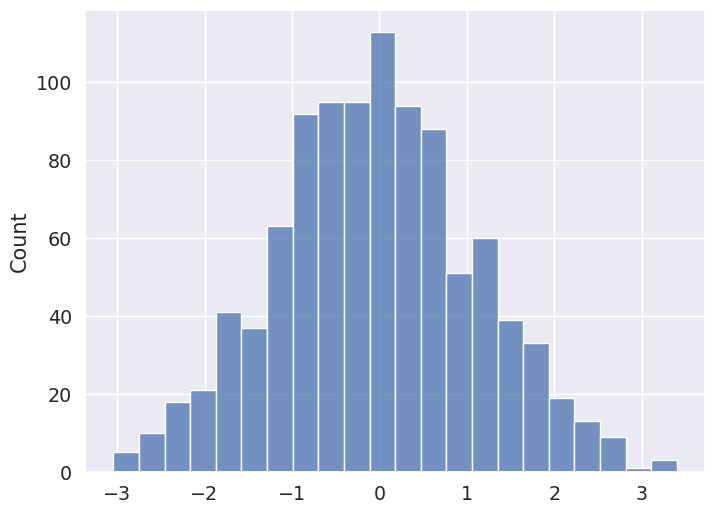

In [2]:
pos = torch.empty(1000,4).uniform_(-1,1).sum(1)
ax = sns.histplot(pos)

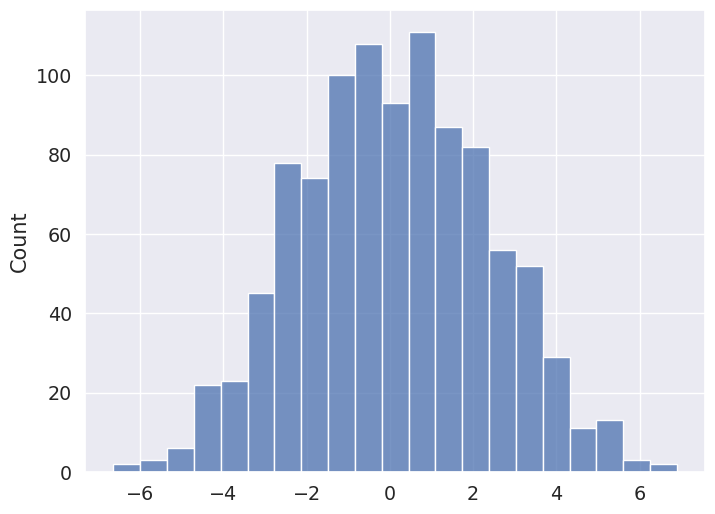

In [3]:
pos = torch.empty(1000,16).uniform_(-1,1).sum(1)
ax = sns.histplot(pos)

Here’s another way to get a normal distribution. Suppose
the growth rate of an organism is influenced by a dozen loci, each with several alleles that
code for more growth. Suppose also that all of these loci interact with one another, such that
each increase growth by a percentage. This means that their effects multiply, rather than add.
For example, we can sample a random growth rate for this example with this line of code

In [4]:
(1 + torch.empty(12).uniform_(0, 0.1)).prod()

tensor(1.5101)

This code just samples 12 random numbers between 1.0 and 1.1, each representing a pro-
portional increase in growth. Thus 1.0 means no additional growth and 1.1 means a 10%
increase. The product of all 12 is computed and returned as output. Now what distribution
do you think these random products will take? Let’s generate 10,000 of them and see:

/tmp/ipykernel_15422/3117868909.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(growth, hist=False)


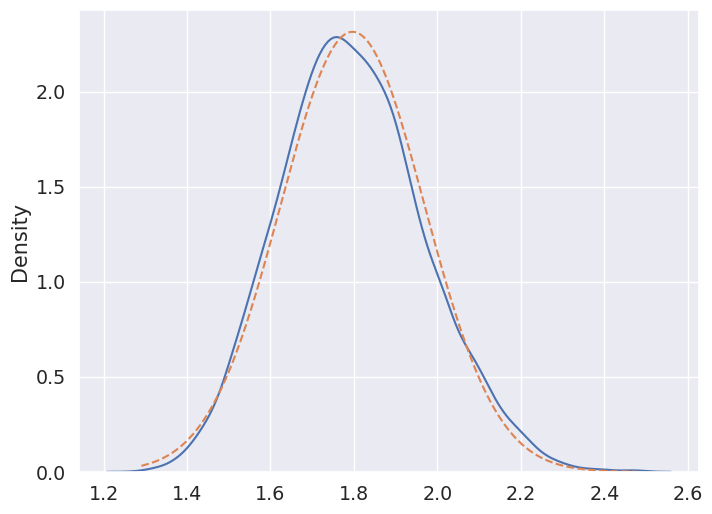

In [5]:
growth = (1 + torch.empty(10000, 12).uniform_(0, 0.1)).prod(1)
# blue line
sns.distplot(growth, hist=False)
# orange line
ax = sns.lineplot(x=growth, y=dist.Normal(growth.mean(),
                                      growth.std()).log_prob(growth).exp())
ax.lines[1].set_linestyle("--")

The smaller the effect of each locus, the better this additive approximation will be. In this
way, small effects that multiply together are approximately additive, and so they also tend to
stabilize on Gaussian distributions. **Verify this for yourself by comparing:**

tensor([17.3265, 11.5923, 43.3534,  ..., 12.0971, 10.6445, 12.3531])


<AxesSubplot: ylabel='Density'>

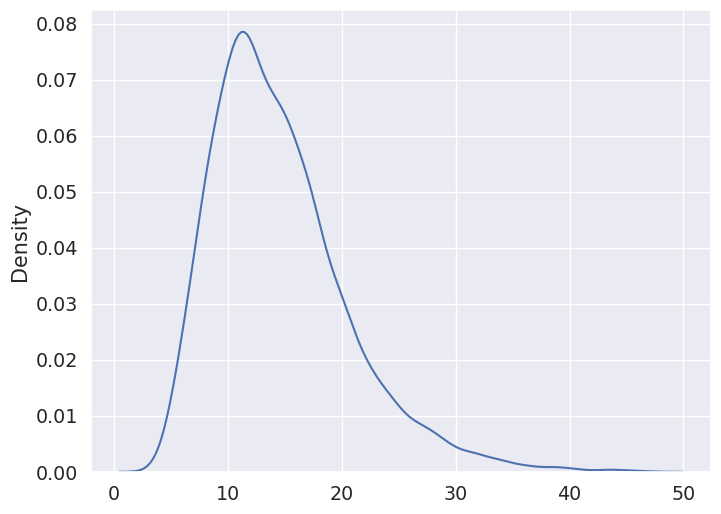

In [6]:
big = (1 + torch.empty(10000, 12).uniform_(0, 0.5)).prod(1)
small = (1 + torch.empty(10000, 12).uniform_(0, 0.01)).prod(1)
print(big)
sns.kdeplot(big)

tensor([1.0748, 1.0440, 1.0762,  ..., 1.0591, 1.0568, 1.0691])


<AxesSubplot: ylabel='Density'>

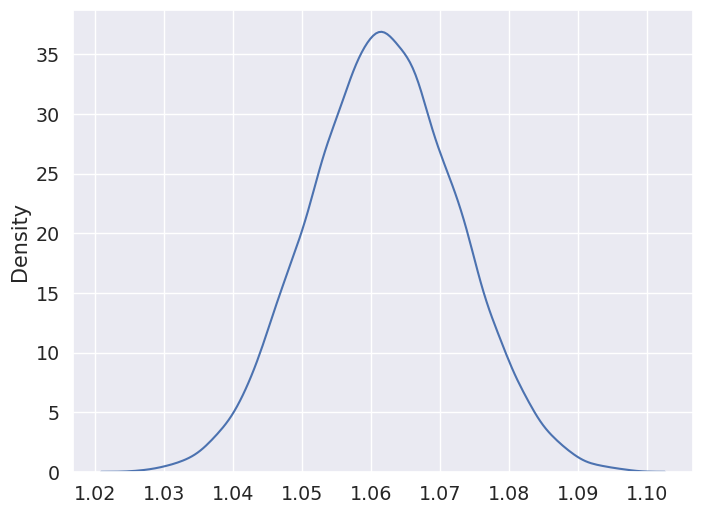

In [7]:
print(small)
sns.kdeplot(small)

Large deviates that are multi-
plied together do not produce Gaussian distributions, but they do tend to produce Gaussian
distributions on the log scale.

Yet another Gaussian distribution. **We get the Gaussian distribution back**, because adding
logs is equivalent to multiplying the original numbers. So even multiplicative interactions
of large deviations can produce Gaussian distributions, once we measure the outcomes on
the log scale. Since measurement scales are arbitrary, there’s nothing suspicious about this
transformation. After all, it’s natural to measure sound and earthquakes and even informa-
tion (Chapter 6) on a log scale.

<AxesSubplot: ylabel='Density'>

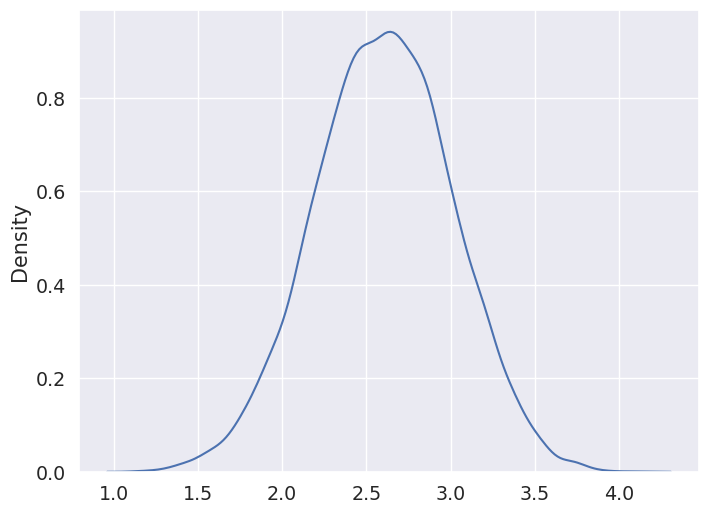

In [8]:
log_big = (1 + torch.empty(10000, 12).uniform_(0, 0.5)).prod(1).log()
sns.kdeplot(log_big)

In later chapters, we’ll see how other useful and common patterns,
like the exponential and gamma and Poisson, also arise from natural processes. The Gauss-
ian is a member of a family of fundamental natural distributions known as the **exponential
family**. All of the members of this family are important for working science, because they
populate our world

# 4.2

This book adopts a standard language for describing and coding statistical models. You
find this language in many statistical texts and in nearly all statistical journals, as it is general
to both Bayesian and non-Bayesian modeling. Scientists increasingly use this same language
to describe their statistical methods, as well. So learning this language is an investment, no
matter where you are headed next.

(1) We recognize a set of measurements that we hope to predict or understand, the **outcode variable(s)**.

(2) For each outcome variable(s), we define a **likelihood distribution** that defines the plausibility of individual observations. In linear regression, this distribution is always Gaussian.

(3) The n we recognize a set of other measurements that we hope to use to predict or understand the outcome. Call these **predictor variables**.

(4) We relate the exact shape of the likelihood distributions - its precise location and other aspects of its shape - to the predictor varaibles. In choosing a way to relate the predictors to the outcomes, we are forced to name and efine all of the parameters of the model.

(5) Finally, we choose **priors** for all of the parameters in the model. These priors define the initial information state of the model, before seeing the data.

--------------------------

w ~ Binomial(n,p)

p ~ Uniform(0,1)

For now, we’ll focus on simple models like the above. In these models, the first line de-
fines the likelihood function used in Bayes’ theorem. The other lines define priors. Both of
the lines in this model are stochastic, as indicated by the ~ symbol.  stochastic relation-
ship is just a mapping of a variable or parameter onto a distribution. It is stochastic because
no single instance of the variable on the left is known with certainty. Instead, the mapping is
probabilistic: Some values are more plausible than others, but very many different values are
plausible under any model.

In [9]:
w, n = 6., 9.
p_grid = torch.linspace(start=0, end=1, steps=1000)
posterior = (dist.Binomial(n, p_grid).log_prob(torch.tensor(w)).exp() * dist.Uniform(0,1).log_prob(p_grid).exp())
posterior = posterior / posterior.sum()

print(posterior.shape)
print(posterior)

torch.Size([1000])
tensor([2.4130e-42, 8.4336e-19, 5.3813e-17, 6.1112e-16, 3.4234e-15, 1.3020e-14,
        3.8760e-14, 9.7442e-14, 2.1646e-13, 4.3751e-13, 8.2075e-13, 1.4496e-12,
        2.4359e-12, 3.9257e-12, 6.1052e-12, 9.2078e-12, 1.3521e-11, 1.9393e-11,
        2.7244e-11, 3.7569e-11, 5.0951e-11, 6.8070e-11, 8.9711e-11, 1.1677e-10,
        1.5028e-10, 1.9140e-10, 2.4144e-10, 3.0186e-10, 3.7431e-10, 4.6060e-10,
        5.6276e-10, 6.8300e-10, 8.2377e-10, 9.8773e-10, 1.1778e-09, 1.3972e-09,
        1.6494e-09, 1.9380e-09, 2.2672e-09, 2.6413e-09, 3.0651e-09, 3.5434e-09,
        4.0818e-09, 4.6861e-09, 5.3623e-09, 6.1171e-09, 6.9575e-09, 7.8908e-09,
        8.9251e-09, 1.0069e-08, 1.1330e-08, 1.2720e-08, 1.4246e-08, 1.5920e-08,
        1.7753e-08, 1.9757e-08, 2.1943e-08, 2.4324e-08, 2.6913e-08, 2.9725e-08,
        3.2774e-08, 3.6075e-08, 3.9645e-08, 4.3501e-08, 4.7658e-08, 5.2137e-08,
        5.6955e-08, 6.2133e-08, 6.7690e-08, 7.3649e-08, 8.0031e-08, 8.6860e-08,
        9.4158e-08, 1

# 4.3

We want our Bayesian machine to consider every possible distribution,
each defined by a combination of $\mu$ and $\sigma$, and rank them by posterior plausibility. Posterior
plausibility provides a measure of the logical compatibility of each possible distribution with
the data and model

In practice we use approximations, so we won't really consider every possible value of $\mu$ and $\sigma$. Importantly, we need to keep in mind that the 'estimate' here will be the _entire posterior distribution_, not any point within it. And as a result, the posterior distribution will be a _distribution of Gaussian distributions_.

The data contained in _data(Howell1)_ are partial census data for the Dobe
area !Kung San, compiled from interviews conducted by Nancy Howell in the late 1960s.64
For the non-anthropologists reading along, the !Kung San are the most famous foraging
population of the 20th century, largely because of detailed quantitative studies by people like
Howell

In [10]:
howell1 = pd.read_csv('../data/Howell1.csv', sep=';')
d = howell1

In [11]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


In [12]:
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [13]:
d['height']

0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

In [14]:
# filter out children from dataset
d2 = d[d['age'] >= 18]
d2_height = torch.tensor(d2['height'], dtype = torch.float)
d2_height.shape

torch.Size([352])

We’ll be working with the data frame d2 now. It should have 352 rows (individuals) in it.

Our goal is to model these values using a Gaussian distribution.

In [15]:
d2_height.std()

tensor(7.7423)

<AxesSubplot: ylabel='Density'>

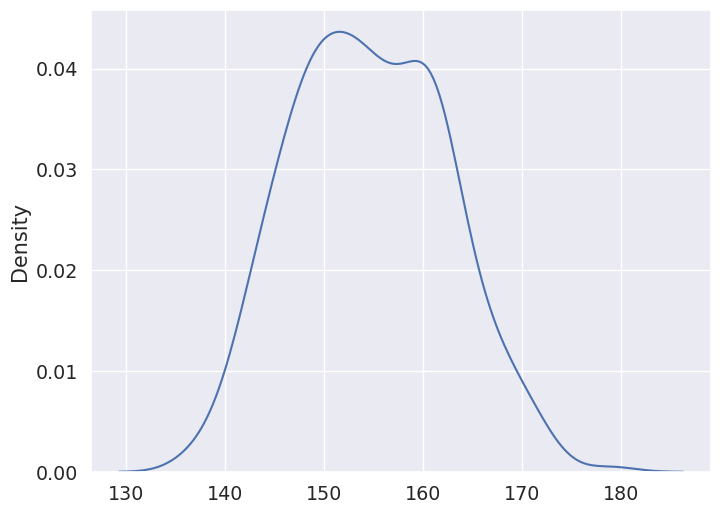

In [16]:
sns.kdeplot(d2_height)

It is conventional to use i because it stands for index. The index i takes on
row numbers, and so in this example can take any value from 1 to 352.

Before long, those little i’s are going to show up on the right-hand side of the
model definition, and you’ll be able to see why we must bother with them. So don’t ignore
the i, even if it seems like useless ornamentation right now

$h_i$ ~ Normal($\mu$, $\sigma$)

$\mu$ ~ Normal(178,20)

$\sigma$ ~ Uniform(0,50)

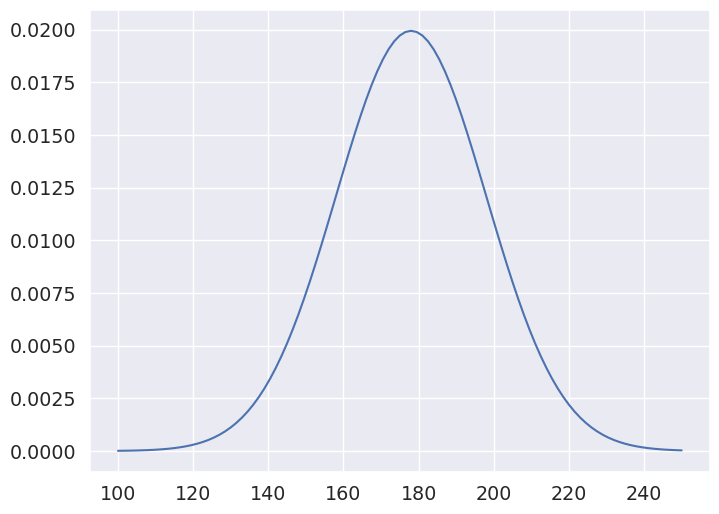

In [17]:
# gaussian shape of mu
x = torch.linspace(100, 250, 101)
sns.lineplot(x=x, y=dist.Normal(178,20).log_prob(x).exp());

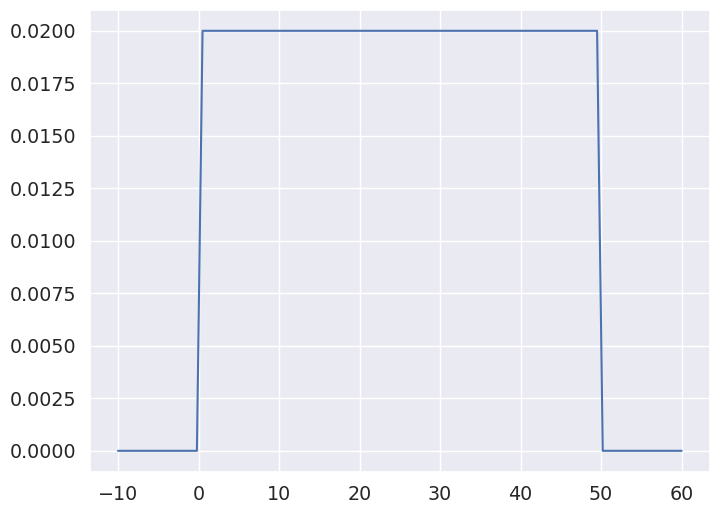

In [18]:
# flat prior for sigma
x = torch.linspace(-10,60,101)
sns.lineplot(x=x, y=dist.Uniform(0,50,validate_args=False).log_prob(x).exp());

You didn’t specify a prior probability distribution of heights
directly, but once you’ve chosen priors for $\mu$ and $\sigma$, these imply a prior distribution of individual heights.

You can quickly simulate heights by sampling from the prior, like you sampled from the posterior back in Chapter 3.

Remember, every posterior is also potentially a
prior for a subsequent analysis, so you can process priors just like posteriors

/tmp/ipykernel_15422/2280096246.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prior_h)


<AxesSubplot: ylabel='Density'>

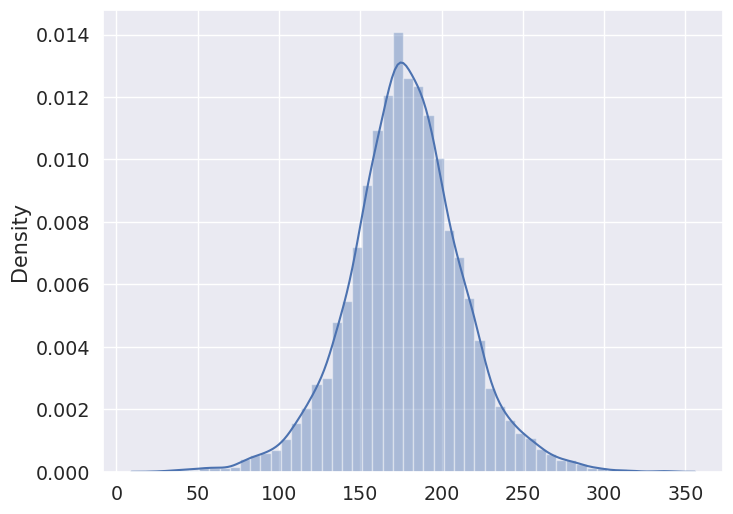

In [19]:
sample_mu = torch.empty(int(1e4)).normal_(178,20)
sample_sigma = torch.empty(int(1e4)).uniform_(0,50)
prior_h = dist.Normal(sample_mu, sample_sigma).sample()
sns.distplot(prior_h)

The density plot you get shows a vaguely bell-shaped density with thick tails. It is **the expected
distribution of heights, averaged over the prior**. Notice that the prior probability distribution
of height is not itself Gaussian. This is okay. The distribution you see is not an empirical
expectation, but rather the distribution of relative plausibilities of different heights, before
seeing the data.

/tmp/ipykernel_15422/279402432.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prior_h)


<AxesSubplot: ylabel='Density'>

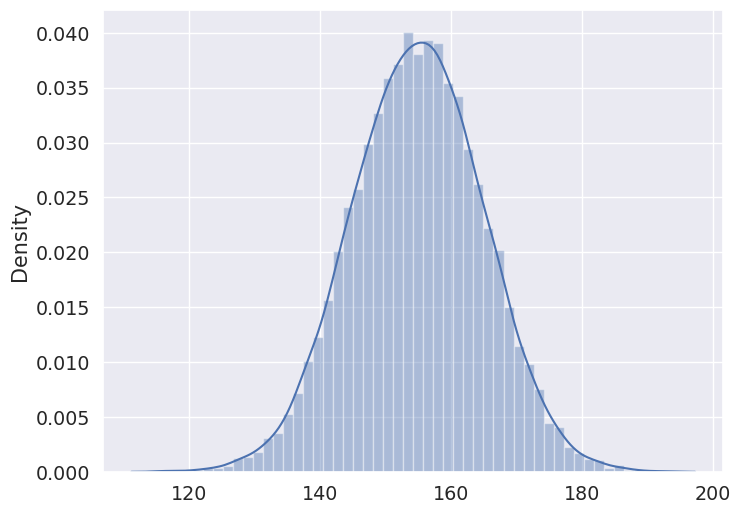

In [20]:
# Play around with the numbers in the priors above, to explore their effects on the prior probability density of heights.
sample_mu = torch.empty(int(1e4)).normal_(155,10)
sample_sigma = torch.empty(int(1e4)).uniform_(0,2)
prior_h = dist.Normal(sample_mu, sample_sigma).sample()
sns.distplot(prior_h)

**Grid approximation of the posterior distribution**

Since this is the first Gaussian
model in the book, and indeed the first model with more than one parameter, it’s worth
quickly mapping out the posterior distribution through brute force calculations. This isn’t
the approach I encourage in any other place, because it is laborious and computationally ex-
pensive.

Indeed, it is usually so impractical as to be essentially impossible. But as always, it
is worth knowing what the target actually looks like, before you start accepting approxima-
tions of it. A little later in this chapter, you’ll use quadratic approximation to estimate the
posterior distribution, and that’s the approach you’ll use for several chapters more

In [21]:
mu_list = torch.linspace(start=140, end=160, steps=200)
sigma_list = torch.linspace(start=4, end=9, steps=200)
post = {"mu": mu_list.expand(200, 200).reshape(-1),
        "sigma": sigma_list.expand(200, 200).t().reshape(-1)}
post_LL = dist.Normal(post["mu"],
                      post["sigma"]).log_prob(d2_height.unsqueeze(1)).sum(0)
post_prod = (post_LL + dist.Normal(178, 20).log_prob(post["mu"])
             + dist.Uniform(0, 50).log_prob(post["sigma"]))
post_prob = (post_prod - max(post_prod)).exp()

You can inspect this posterior distribution, now residing in *post_prob*, using a variety of
plotting commands. You can get a simple contour plot:

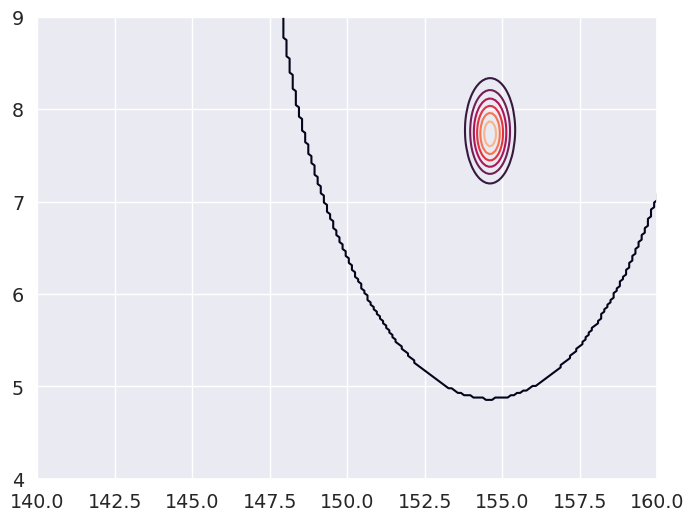

In [22]:
_, ax = sns.mpl.pyplot.subplots()
ax.contour(post["mu"].reshape(200, 200), post["sigma"].reshape(200, 200),post_prob.reshape(200, 200));

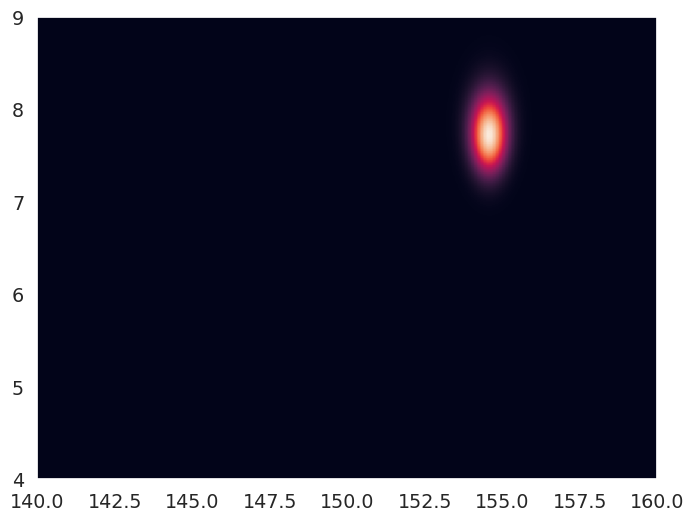

In [23]:
_, ax = sns.mpl.pyplot.subplots()
ax.imshow(post_prob.reshape(200, 200), origin="lower",
          extent=(140, 160, 4, 9), aspect="auto")
ax.grid(False)

To study this posterior distribution in more detail,
again I’ll push the flexible approach of sampling parameter values from it. The only new trick is that since there are two parameters, and
we want to sample combinations of them, we first randomly sample row numbers in *post*
in proportion to the values in *post-prob*. Then we pull out the parameter values on those
randomly sampled rows. This code will do it:

In [24]:
sample_rows = torch.multinomial(input=post_prob, num_samples=int(1e4),replacement=True)
sample_mu = post['mu'][sample_rows]
sample_sigma = post['sigma'][sample_rows]

You end up with 10,000 samples, with replacement, from the posterior for the height data.

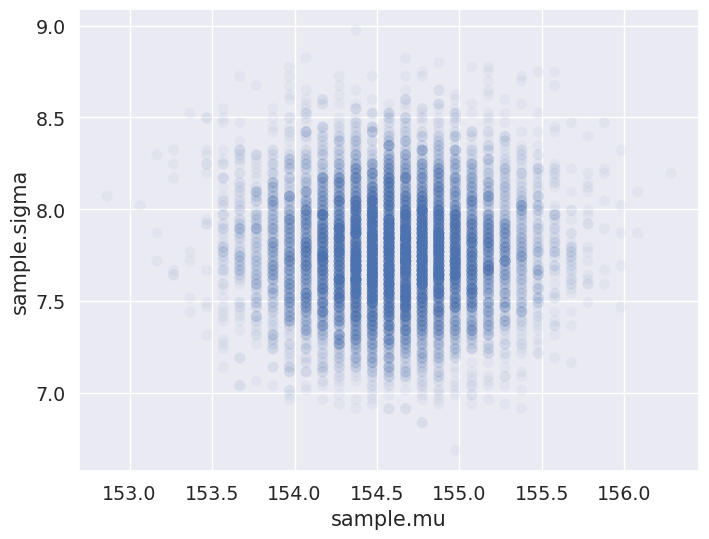

In [25]:
ax = sns.scatterplot(x=sample_mu, y=sample_sigma, s=64, alpha=0.05, edgecolor="none")
ax.set(xlabel="sample.mu", ylabel="sample.sigma");

Now that you have these samples, you can describe the distribution of confidence in each
combination of $\mu$ and $\sigma$ by summarizing the samples. Characterize the shapes of the _marginal_ posterior
densities of $\mu$ and $\sigma$. The jargon “marginal” here means “averaging over the other parameters.”

/tmp/ipykernel_15422/132698125.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_mu)


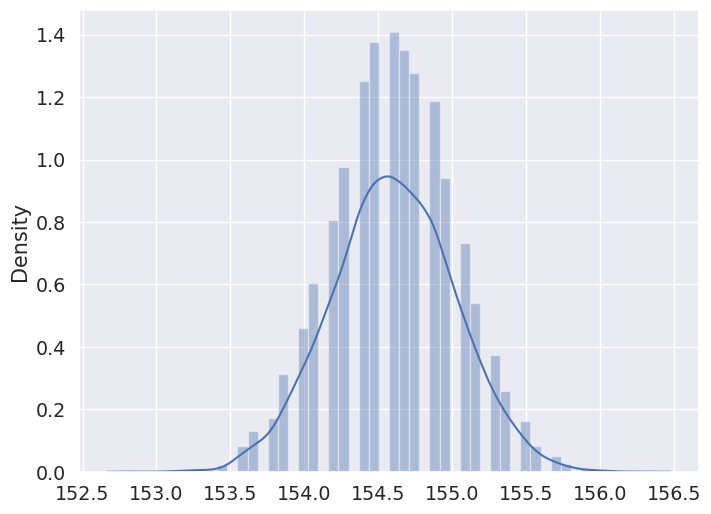

/tmp/ipykernel_15422/132698125.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_sigma);


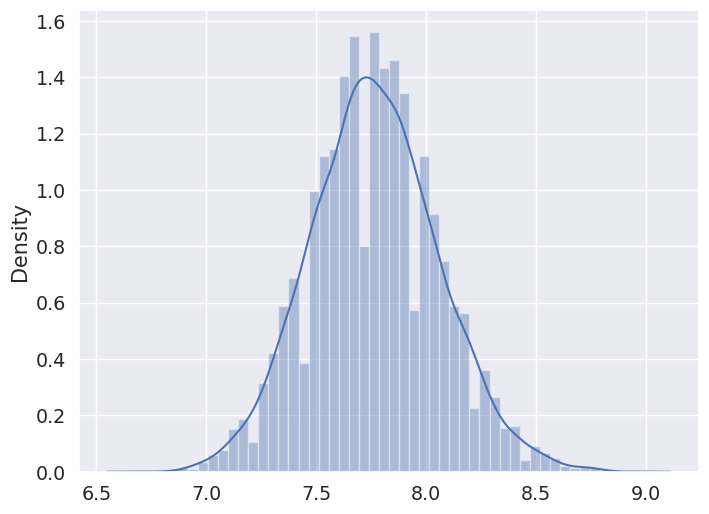

In [26]:
sns.distplot(sample_mu)
sns.mpl.pyplot.show()
sns.distplot(sample_sigma);

These densities are very close to being normal distributions. And
this is quite typical. As sample size increases, posterior densities approach the normal distri-
bution. If you look closely, though, you’ll notice that the density for $\sigma$ has a longer right-hand
tail. I’ll exaggerate this tendency a bit later, to show you that this condition is very common
for standard deviation parameters

In [27]:
print(stats.hpdi(sample_mu, 0.89))
print(stats.hpdi(sample_sigma, 0.89))


tensor([153.9698, 155.2764])
tensor([7.2663, 8.1960])


In [28]:
d3 = stats.resample(d2_height, num_samples=20)

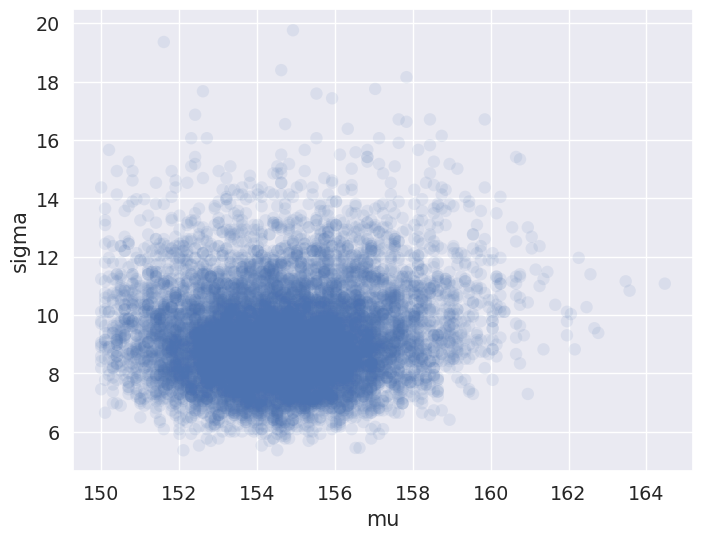

In [29]:
mu_list = torch.linspace(start=150, end=170, steps=200)
sigma_list = torch.linspace(start=4, end=20, steps=200)
post2 = {"mu": mu_list.expand(200, 200).reshape(-1),
         "sigma": sigma_list.expand(200, 200).t().reshape(-1)}
post2_LL = dist.Normal(post2["mu"], post2["sigma"]).log_prob(d3.unsqueeze(1)).sum(0)
post2_prod = (post2_LL + dist.Normal(178, 20).log_prob(post2["mu"])
              + dist.Uniform(0, 50).log_prob(post2["sigma"]))
post2_prob = (post2_prod - max(post2_prod)).exp()
sample2_rows = torch.multinomial(input=post2_prob, num_samples=int(1e4),
                                 replacement=True)
sample2_mu = post2["mu"][sample2_rows]
sample2_sigma = post2["sigma"][sample2_rows]
ax = sns.scatterplot(x=sample2_mu, y=sample2_sigma, s=80, alpha=0.1, edgecolor="none")
ax.set(xlabel="mu", ylabel="sigma");

/tmp/ipykernel_15422/2257661258.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample2_sigma, hist=False)


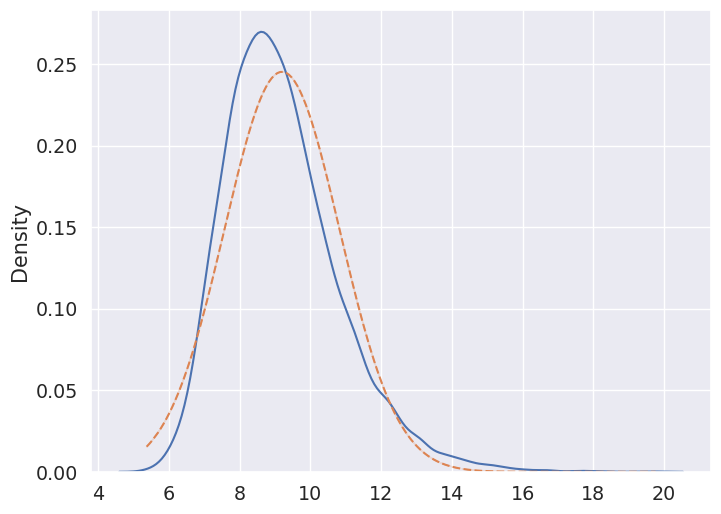

In [30]:
sns.distplot(sample2_sigma, hist=False)
ax = sns.lineplot(x=sample2_sigma, y=dist.Normal(sample2_sigma.mean(), sample2_sigma.std())
                  .log_prob(sample2_sigma).exp())
ax.lines[1].set_linestyle("--")

**Fitting the model with maximum a posteriori (MAP) estimate**.

Our interest in
quadratic approximation, recall, is as a handy way to quickly make inferences about the shape
of the posterior. The posterior’s peak will lie at the maximum a posteriori estimate (MAP),
and we can get a useful image of the posterior’s shape by using the quadratic approximation
of the posterior distribution at this peak.

To find the values of $\mu$ and $\sigma$ that maximize the posterior probability, we’ll use map,
a command in the rethinking package. The way that map works is by using the model
definition you were introduced to earlier in this chapter. Each line in the definition has
a corresponding definition in the form of R code. The engine inside map then uses these
definitions to define the posterior probability at each combination of parameter values. Then
it can climb the posterior distribution and find the peak, its MAP.

In [55]:
howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = howell1
d2 = d[d["age"] >= 18]

In [64]:
def flist(height):
    mu = pyro.sample("mu", dist.Normal(178, 1))
    sigma = pyro.sample("sigma", dist.Uniform(0, 50))
    with pyro.plate("plate"):
        pyro.sample("height", dist.Normal(mu, sigma), obs=height)

**Skipping this section because of errors, issue submitted at https://github.com/fehiepsi/rethinking-pyro/issues/5**

In [65]:
d2_height = torch.tensor(d2["height"], dtype=torch.float)
m4_1 = MAP(flist).run(d2_height)

In [71]:
precis(m4_1)

,Mean,StdDev,|0.89,0.89|
mu,178.33,1.46,176.10,180.73
sigma,28.19,2.30,24.56,31.78


**Note that in the original R implementation (which also didn't throw an error for dist.Normal(178,20)), the _precis_ output was supposed to give the 5% and 94.5% quantiles (corresponding to default 89% interval). But this seems to be a specific thing for the Pyro implementation when I inspect the _precis_ source code in _rethinking.py.**

These numbers provide Gaussian approximations for each parameter’s marginal distribution.
This means the plausibility of each value of $\mu$, after averaging over the plausibilities of each
value of $\sigma$, is given by a Gaussian distribution with mean 154.6 and standard deviation 0.4.

The priors we used before are very weak, both because they are nearly flat and because
there is so much data. So I’ll splice in a more informative prior for $\mu$, so you can see the effect.
All I’m going to do is change the standard deviation of the prior to 0.1, so it’s a very narrow
prior. I’ll also build the formula right into the call to map, so you can see how to build it all
at once.

In [50]:
def model(height):
    mu = pyro.sample("mu", dist.Normal(178, 0.1))
    sigma = pyro.sample("sigma", dist.Uniform(0, 50))
    with pyro.plate("plate"):
        pyro.sample("height", dist.Normal(mu, sigma), obs=height)

m4_2 = MAP(model).run(d2_height)
precis(m4_2)

,Mean,StdDev,|0.89,0.89|
mu,178.02,0.10,177.86,178.18
sigma,23.09,0.79,21.92,24.41


Notice that the estimate for $\mu$ has hardly moved off the prior. The prior was very concentrated
around 178. So this is not surprising. **But also notice that the estimate for $\sigma$ has changed quite a lot**, even though we didn’t change its prior at all. Once the golem is certain that the mean
is near 178 - as the prior insists - then the golem has to estimate $\sigma$ conditional on that fact.
This results in a different posterior for $\sigma$, even though all we changed is prior information
about the other parameter.

**Variance-covariance matrix.** It is the multi-dimensional glue of a qua-
dratic approximation, because it tells us how each parameter relates to every other param-
eter in the posterior distribution. A variance-covariance matrix can be factored into two elements: (1) a vector of variances for the parameters and (2) a correlation matrix that tells
us how changes in any parameter lead to correlated changes in the other.

In [53]:
vcov(m4_1)

tensor([[0.0100, 0.0093],
        [0.0093, 0.8170]])

Decomposition

In [54]:
print(vcov(m4_1).diag())
cov = vcov(m4_1)
print(cov / cov.diag().ger(cov.diag()).sqrt())

tensor([0.0100, 0.8170])
tensor([[1.0000, 0.1028],
        [0.1028, 1.0000]])


(1) is the list of variances, the square root of this will give the same results as _StdDev_ from the _precis_ function.

(2) is the correlation matrix of the parameter pairs. 1s are self-correlations, and other values are correlations between parameter pairs. Since these values are quite close to zero, it indicates that learning $\mu$ learns us quite little about $\sigma$ and vice versa.

Now we will extend to sample from this multi-dimensional posterior, instead of sampling single values from a simple Gaussian.

In [67]:
post = extract_samples(m4_1)
{latent: post[latent][:5] for latent in post}

{'mu': tensor([179.8012, 178.6650, 177.0728, 175.9985, 179.7355]),
 'sigma': tensor([28.7744, 25.8208, 27.0834, 22.1534, 29.5629])}

In [68]:
precis(m4_1)

,Mean,StdDev,|0.89,0.89|
mu,178.33,1.46,176.10,180.73
sigma,28.19,2.30,24.56,31.78


In [69]:
precis(post)

,Mean,StdDev,|0.89,0.89|
mu,178.33,1.46,176.10,180.73
sigma,28.19,2.30,24.56,31.78


These samples also preserve the covariance between $\mu$ and $\sigma$. This hardly matters right
now, because $\mu$ and $\sigma$ don’t covary at all in this model. But once you add a predictor variable
to your model, covariance will matter a lot.


The quadratic assumption for $\sigma$ can be problematic, as seen on
page 85. A conventional way to improve the situation is the estimate log($\sigma$) instead. Why does this
help? While the posterior distribution of $\sigma$ will often not be Gaussian, the distribution of its logarithm
can be much closer to Gaussian. So if we impose the quadratic approximation on the logarithm, rather
than the standard deviation itself, we can often get a better approximation of the uncertainty.

In [72]:
def model(height):
    mu = pyro.sample("mu", dist.Normal(178, 20))
    log_sigma = pyro.sample("log_sigma", dist.Normal(2, 10))
    with pyro.plate("plate"):
        pyro.sample("height", dist.Normal(mu, log_sigma.exp()), obs=height)

m4_1_logsigma = MAP(model).run(d2_height)

Notice the exp inside the likelihood. That converts a continuous parameter, log_sigma, to be strictly
positive, because $exp(x) > 0$ for any real value x. Notice also the prior for log_sigma. Since
log_sigma is continuous now, it can have a Gaussian prior.
When you extract samples, it is log_sigma that has a Gaussian distribution. To get the distribu-
tion of sigma, you just need to use the same exp as in the model definition, to get back on the natural
scale

In [74]:
post = extract_samples(m4_1_logsigma)
sigma = post["log_sigma"].exp()

# 4.4